# NLP Disaster Tweets Kaggle Mini-Project

## 1 - Introduction

### 1.1 - Project Description and Objective

Twitter has undoubtedly become a powerful tool for communication in times of emergency. With the increasing ubiquity of smartphones, individuals are now able to report events as they happen in real-time. As a result, more organizations are turning to Twitter as a source of information during disasters, including relief organizations and news agencies.

However, the challenge lies in identifying which tweets are truly indicative of an emergency, as not all tweets that contain certain keywords or phrases necessarily correspond to a real disaster. This is where machine learning comes in.

Through the development of a machine learning model, we can predict which tweets are relevant to a disaster and which ones aren't. By leveraging a dataset of 10,000 hand-classified tweets, we can train the model to identify patterns and trends that are indicative of real disasters.

The model will utilize a variety of natural language processing techniques, to determine whether a tweet is likely to be about an emergency. Additionally, the model will be trained on a range of disaster scenarios, including natural disasters such as earthquakes and hurricanes, as well as man-made disasters such as terrorist attacks and industrial accidents.

This kind of model could potentially be used to programatically monitor Twitter in real-time, providing a powerful tool for disaster relief organizations and news agencies. The model could be integrated into existing systems to provide alerts and notifications in the event of an emergency, enabling faster response times and potentially saving lives.

To evaluate the performance of the machine learning algorithm for identifying tweets about disasters, multiple evaluation metrics will be used. The primary evaluation metric will be the F1 score, which is a weighted average of precision and recall. In addition to the F1 score, accuracy, AUC-ROC and MSE will also be calculated to evaluate the model's predictive power. By using multiple evaluation metrics, we can obtain a more nuanced understanding of the algorithm's performance, identifying any strengths and weaknesses in its classification abilities. 

> **Note:** the result of the final model will be submitted to Kaggle to participate in the "Natural Language Processing with Disaster Tweets" competition. See https://www.kaggle.com/c/nlp-getting-started/overview

### 1.2 - Libraries and Constant Definitions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string
import csv
from textblob import TextBlob
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import tensorflow as tf

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout
from tensorflow.keras.layers import LSTM, Bidirectional, GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD

from tensorflow.keras.utils import plot_model

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay

import visualkeras

In [2]:
# Declare random state constant for reproduciblity
RANDOM_STATE = 27

# Path to the GloVe word embedding file
GLOVE_PATH = 'C:\Downloads\MSDS\DTSA5511\RNN\data'

# Path to the train and test data
DATA_PATH = './data'

# Path to the result submission
SUBMISSION_PATH = './submission'

## 2 - Data Load and Inspection

In [62]:
# Only needed if running on Colab
# !wget -P 'data/' 'https://raw.githubusercontent.com/rogolive2000/MSDS-DTSA5511-RNN-Project/main/abbreviations.csv'
# !wget -P 'data/' 'https://raw.githubusercontent.com/rogolive2000/MSDS-DTSA5511-RNN-Project/main/test.csv'
# !wget -P 'data/' 'https://raw.githubusercontent.com/rogolive2000/MSDS-DTSA5511-RNN-Project/main/train.csv'

In [4]:
# Dataset to be used for train and test split
train_df = pd.read_csv(DATA_PATH + '/train.csv')

# Dataset used for results submission 
test_df = pd.read_csv(DATA_PATH + '/test.csv')

# Dataset with common abbreviations to be used for cleaning
abbrev_df = pd.read_csv(DATA_PATH + '/abbreviations.csv')

### 2.1 - Visual Inspection

Upon a brief examination of the training data, it becomes evident that substantial cleaning is necessary. The dataset contains numerous special characters and other types of data that have the potential to disrupt the model training process.

In [5]:
train_df.sample(10, random_state=RANDOM_STATE)

,id,keyword,location,text,target
2111,3034,death,NaN,New crime: knowing your rights. Punishable by ...,0
1731,2494,collided,NaN,It's Even Worse Than It Looks: How the America...,0
987,1432,body%20bagging,ATL ? SEA,Drake is really body bagging meek,0
1216,1754,buildings%20burning,Selma2Oakland,People are more worried about the burning of b...,1
1127,1625,bombed,"Ikeja, Nigeria",70 years ago today the United States of Americ...,1
4613,6556,injury,Los Angeles,Dr Jack Stern Interview Ending Back Pain for #...,0
2011,2887,damage,NaN,@WonderousAllure crosses her arms to cover her...,0
4539,6453,injured,Worldwide,Top Stories - Google 4 dead dozens injured in ...,1
4132,5875,hailstorm,far away,Calgary news weather and traffic for August 5 ...,0
702,1010,blazing,Suitland,@OfficialTJonez Your 'Lost For Words' made me ...,0


### 2.2 - Data Format

The dataset is relatively small, consisting of 7613 observations for the training set and 3263 observations for the test set, which presents a challenge for model building. It should be noted that the target column is absent from the test set, as it is intended for result submission to Kaggle.

In [6]:
pd.DataFrame([[train_df.shape[1], train_df.shape[0]], 
             [test_df.shape[1], test_df.shape[0]]],              
             columns=['Features', 'Observations'], 
             index=['Train data', 'Test data'])

,Features,Observations
Train data,5,7613
Test data,4,3263


### 2.3 - Metadata Information

Based on the summary below, the "text" column will be the primary feature utilized for predicting the target column, which can either be a 1 for a real disaster or a 0 for a non-disaster event. The id column will not be utilized, while the keyword and location columns will solely serve for reporting and visualizations purposes.

|Column Name|Description|Pandas Data Type|
|:-|:-|:-:|
|id|Unique identifier for each tweet|int64|
|keyword|A particular keyword from the tweet|object (string)|
|location|The location the tweet was sent from (may be blank)|object (string)|
|text|The text of the tweet|object (string)|
|target|Denotes whether a tweet is about a real disaster (1) or not (0)|object (string)|

> **Notes:**
> * Target column only present in the train dataset
> * Information from: https://www.kaggle.com/competitions/nlp-getting-started/data

In [7]:
print('Training data format\n')
train_df.info()

Training data format

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
print('Test data format\n')
test_df.info()

Test data format

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


### 2.4 - Evaluating for Missing Data

There is no missing data present in the relevant columns of interest, namely the "text" and "target" columns. This will slightly simplify the data cleaning process.

In [9]:
pd.DataFrame({'Number of Nulls (Train Data)': 
              train_df.isnull().sum()})

,Number of Nulls (Train Data)
id,0
keyword,61
location,2533
text,0
target,0


In [10]:
pd.DataFrame({'Number of Nulls (Test Data)': 
              test_df.isnull().sum()})

,Number of Nulls (Test Data)
id,0
keyword,26
location,1105
text,0


### 2.5 - Evaluating for Duplicate Data

To identify duplicated data, I have adopted a strategy that incorporates the text, keyword, and target columns for the training dataset, and the text and keyword columns for the test dataset. By considering these columns as a subset of text, I believe this approach provides a more comprehensive representation, as the same text may have been used in various contexts.

In [11]:
pd.DataFrame([[train_df.duplicated(subset=['text', 'keyword', 'target']).sum()], 
             [test_df.duplicated(subset=['text', 'keyword']).sum()]],              
             columns=['Duplicate Observations'], 
             index=['Train data', 'Test data'])

,Duplicate Observations
Train data,72
Test data,16


## 3 - Data Cleaning

Data cleaning is an essential step in natural language processing (NLP) that involves preparing text data for analysis by removing irrelevant or noisy information and standardizing the format of the text. Some common data cleaning techniques used in NLP include tokenization, which splits text into individual words or phrases, and stop word removal, which removes commonly used words that do not carry much meaning, such as "the" or "and". Data cleaning can help improve the accuracy and effectiveness of NLP models by reducing the amount of irrelevant information and standardizing the format of the text to make it easier to analyze.

In [12]:
# Download nltk data - only needed once
# nltk.download('stopwords')
# nltk.download('punkt')

In [13]:
class DataCleaning():
    """
    Class to perform various data-cleaning (pre-processing) tasks
    See individual methods for details
    """
    def __init__(self):
        
        # Will be updated with classes names once encoded
        self.class_labels = None
        
        return
    
    def remove_duplicates(self, df, subset):
        """
        Remove duplicate entries in a dataframe
        df........: Pandas dataframe to be cleaned
        subset....: List of column for cleaning
        Returns...: Cleaned dataframe
        """
        return df.drop_duplicates(subset=subset)
    
    def remove_punctuation(self, df, subset):
        """
        Remove punctuation from text in dataframe
        df........: Pandas dataframe to be cleaned
        subset....: String to select column for cleaning
        Returns...: Cleaned column        
        """
        return df[subset].apply(lambda x: re.sub(r'[^\w\s]+', '', x))

    def remove_numbers(self, df, subset):
        """
        Remove numbers from text in dataframe
        df........: Pandas dataframe to be cleaned
        subset....: String to select column for cleaning
        Returns...: Cleaned column   
        """
        return df[subset].apply(lambda x: re.sub(r'[0-9]+', '', x))   

    def remove_extra_spaces(self, df, subset):
        """
        Remove extra spaces from text in dataframe
        df........: Pandas dataframe to be cleaned
        subset....: String to select column for cleaning
        Returns...: Cleaned column    
        """
        # Remove leading and trailing white spaces
        df[subset] = df[subset].str.strip()
        
        # Replace consecutive white spaces with a single white space
        df[subset] = df[subset].str.replace(r'\s+', ' ', regex=True)        

        return df[subset]

    def replace_abbreviations(self, df, subset, abbrev_dict):
        """
        Replace abbreviations with descriptions
        df.........: Pandas dataframe to be cleaned
        subset.....: String to select column for cleaning
        abbrev_dict: Dictionary with abbreviations and replacements
        Returns....: Cleaned column    
        """    
        return df[subset].apply(self.replace_abbreviations_helper)
    
    def replace_abbreviations_helper(self, text):    
        """
        Helper function to Replace abbreviations with descriptions,
            allowing it to be applied to a column in a Pandas dataframe
        text......: Text to be cleaned
        Returns...: Cleaned text
        """           
        # Tokenize the input text into individual words
        tokens = word_tokenize(text)
        
        # Replace each abbreviation in the tokenized text with its 
        #   corresponding value from the dictionary
        # If a word is not an abbreviation, keep it as it is
        tokens = [abbrev_dict.get(word.lower()) 
                  if word.lower() in abbrev_dict.keys() 
                  else word for word in tokens] 
        
        # Join the tokens back into a single string with spaces in between
        text = ' '.join(tokens)        
                               
        return(text)
        
    def remove_non_printable(self, df, subset):
        """
        Remove non-printable characters and hyperlinks from text in dataframe
        df........: Pandas dataframe to be cleaned
        subset....: String to select column for cleaning
        Returns...: Cleaned column   
        """   
        return df[subset].apply(self.remove_non_printable_helper)
        
    def remove_non_printable_helper(self, text):
        """
        Helper function to remove non-printable characters and hyperlinks from a text,
            allowing it to be applied to a column in a Pandas dataframe
        text......: Text to be cleaned
        Returns...: Cleaned text
        """   
        # Remove non-printable characters
        text = ''.join([x for x in text if x in string.printable])

        # Remove emojis 
        emoji = re.compile("["
                         u"\U0001F600-\U0001F64F"  # emoticons
                         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                         u"\U0001F680-\U0001F6FF"  # transport & map symbols
                         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                         u"\U00002702-\U000027B0"
                         u"\U000024C2-\U0001F251"
                         "]+", flags=re.UNICODE
                         )
        text = emoji.sub(r'', text)        
        
        # Remove hyperlinks
        text = re.sub(r"http\S+","", text)   
        
        return text
    
    def remove_stopwords(self, df, subset):
        """
        Remove extra stop words from text in dataframe
        df........: Pandas dataframe to be cleaned
        subset....: String to select column for cleaning
        Returns...: Cleaned dataframe   
        """   
        return df[subset].apply(self.remove_stopwords_helper)
    
    def remove_stopwords_helper(self, text):
        """
        Helper function to remove English stop words from a text,
            allowing it to be applied to a column in a Pandas dataframe
        text......: Text to be cleaned
        Returns...: Cleaned text
        """   
        # Define English stopwords
        stop_words = set(stopwords.words('english'))

        # Tokenize text
        word_tokens = word_tokenize(text)

        # Filter stop words from text
        filtered_text = [w for w in word_tokens if not w.lower() in stop_words]

        # Rebuild sentence
        filtered_sentence = ' '.join(filtered_text)

        return filtered_sentence
        
# Initialize class
dc = DataCleaning()

### 3.1 - Remove Duplicates

Text classification datasets often contain a large number of similar or redundant documents, which can increase the size of the dataset and slow down the processing time. Removing duplicates can reduce the number of unique documents and simplify the data. This can improve the computational efficiency of the algorithm and make it easier to work with large datasets and decrease overfitting.

> **Note:** For the validation dataset, I won't be removing duplicates otherwise the submission file to Kaggle will not conform with its expected shape.

In [14]:
# Remove duplicates in train dataset
train_df = dc.remove_duplicates(train_df.copy(), ['text', 'keyword', 'target'])

### 3.2 - Remove Punctuation

Punctuation marks, such as commas, periods, and exclamation points, can add noise to the text data and make it more difficult for the algorithm to accurately classify the documents. Additionally, different forms of punctuation can have varying degrees of significance and can affect the results of the analysis. By removing punctuation, the data can be simplified and made more consistent, which can improve the quality of the results and decrease overfitting.

In [15]:
# Remove punctuation from train and test dataset
train_df['text'] = dc.remove_punctuation(train_df.copy(), 'text')
test_df['text'] = dc.remove_punctuation(test_df.copy(), 'text')

### 3.3 - Remove Remove Stopwords

Stop words are common words that appear frequently in text data and do not carry much meaning, such as "the", "and", "of", etc. While these words can be important for natural language processing tasks such as text summarization or question answering, they are not typically useful for text classification tasks. By removing stop words, the data can be simplified and made more focused, which can improve the quality of the results, reduce the dimensionality of the feature matrix and decreaset overfitting.

In [16]:
# Remove English stopwords from train and test dataset
train_df['text'] = dc.remove_stopwords(train_df.copy(), 'text')
test_df['text'] = dc.remove_stopwords(test_df.copy(), 'text')

### 3.4 - Remove Non-Printable Characters and Hyperlinks

Non-printable characters, such as control characters, can cause issues when processing text, as they are not intended to be seen or printed and can therefore interfere with analysis or modeling. Similarly, hyperlinks may contain irrelevant or biased information that can negatively impact the accuracy of NLP models. Removing non-printable characters and hyperlinks can help improve the quality and accuracy of the text data used for analysis, as it allows the focus to be on the relevant and meaningful text content

In [17]:
# Remove non-rpintable characters from train and test dataset
train_df['text'] = dc.remove_non_printable(train_df.copy(), 'text')
test_df['text'] = dc.remove_non_printable(test_df.copy(), 'text')

### 3.5 - Remove Extra Spaces

Extra spaces can add noise to the text data and make it more difficult for the algorithm to accurately classify the documents. Additionally, different forms of extra spaces can have varying degrees of significance and can affect the results of the analysis. By removing extra spaces, the data can be simplified and made more consistent, which can improve the quality of the results and decrease overfitting.

In [18]:
# Remove extra-spaces from train and test dataset
train_df['text'] = dc.remove_extra_spaces(train_df.copy(), 'text')
test_df['text'] = dc.remove_extra_spaces(test_df.copy(), 'text')

### 3.6 - Convert Abbreviations to Descriptions 

Abbreviations are often used to save space or time when writing, but they can create ambiguity and confusion when processing text with a machine. By converting abbreviations to their full descriptions, the resulting text becomes more human-readable and easier to understand for both humans and machines. This can also improve the performance of NLP models that rely on understanding the meaning of words and phrases in context.

In [19]:
# Create a dictionary with the abbreviation and replacement values
abbrev_dict = abbrev_df.set_index('abbreviation')['description'].to_dict()

train_df['text'] = dc.replace_abbreviations(train_df.copy(), 'text', abbrev_dict)
test_df['text'] = dc.replace_abbreviations(test_df.copy(), 'text', abbrev_dict)

### 3.7 - Clean up Keywords Column

Although the keyword column is not used for the classification, I'm cleaning it up just for consistency and reporting.

In [20]:
# Use the str.replace() method to replace %20 with space
train_df['keyword'] = train_df['keyword'].str.replace('%20', ' ')
test_df['keyword'] = test_df['keyword'].str.replace('%20', ' ')

# Replace NaN values with 'undefined'
train_df['keyword'] = train_df['keyword'].fillna(value='undefined')
test_df['keyword'] = test_df['keyword'].fillna(value='undefined')

In [21]:
train_df.sample(10, random_state=RANDOM_STATE)

,id,keyword,location,text,target
4790,6814,loud bang,"Philadelphia, PA",Nearly heart attack loud bang window next me_t...,1
6374,9109,suicide bomb,Gidi,Pic 16yr old PKK suicide bomber detonated bomb...,1
2306,3309,demolished,"NH via Boston, MA",Colts get demolished Patriots like 5007 whine ...,0
5384,7683,panic,East TN.,biggangVH1 looks like George panic attack laug...,0
1460,2108,casualty,NaN,stavernise France agreed repay Russia two wars...,0
2223,3181,deluge,NaN,Bible sometimes backs truck unloads descriptiv...,0
3092,4438,electrocute,"Texas, USA",would like electrocute everyone uses word fair...,0
7177,10286,weapon,Pennsylvania,70 years ago today US dropped nuclear weapon J...,1
4642,6601,inundated,"Sunbury, Ohio",AssassinKPg Brother dont want friendshipyou wa...,0
2903,4170,drown,NaN,CortneyMo_ put Detroit niggas gone acting tryn...,0


In [64]:
# Writes cleaned data as CSV for external inspection
train_df.to_csv(DATA_PATH + '/cleaned_data.csv', index=False, quoting=csv.QUOTE_ALL)

## 4 - EDA-Exploratory Data Analysis

EDA, or exploratory data analysis, is the process of examining and visualizing data to understand its underlying structure, patterns, and relationships. This approach allows for a preliminary analysis of the data before conducting more complex modeling or statistical analyses. The goal of EDA is to gain insights into the data, identify any outliers, anomalies, or missing values, and determine the appropriate methods for cleaning, transforming, or encoding the data. EDA typically involves various graphical and statistical techniques, such as scatter plots, histograms, box plots, correlation matrices, and summary statistics, to provide a comprehensive overview of the data and facilitate decision-making regarding further analysis.

### 4.1 - Data Distribution

The distribution of classes in the dataset is somewhat imbalanced, with approximately 57% of the samples belonging to class 0 (not a disaster) and 43% belonging to class 1 (disaster). While the dataset can be considered imbalanced, it is not severely so, and is unlikely to pose significant challenges during model building.

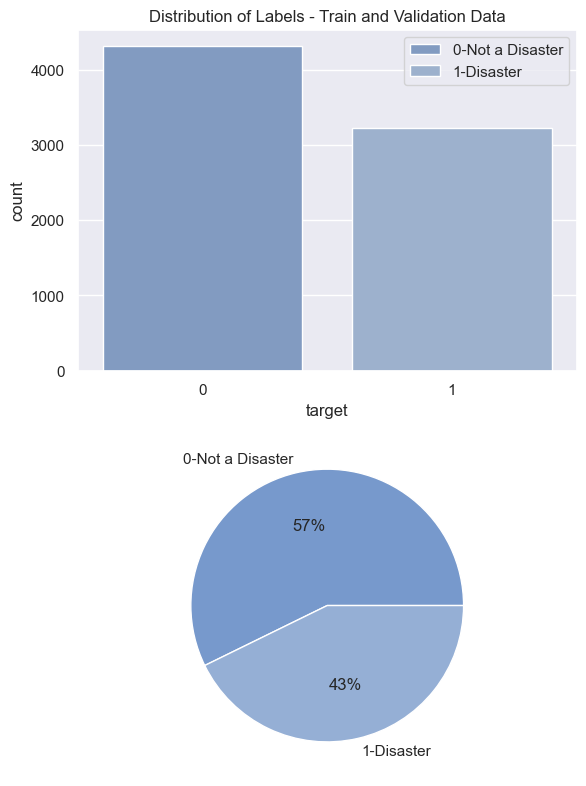

In [63]:
# Initialize figure
fig, axs = plt.subplots(2, 1, figsize=(6, 8))

# Set Seaborn style
sns.set(style='darkgrid')
palette_color = sns.light_palette(color='#79C', reverse=True, n_colors=5)
labels = ['0-Not a Disaster', '1-Disaster']

# Create plots
axs[0] = sns.countplot(x=train_df['target'], hue=train_df['target'], dodge=False,
                       palette=palette_color, ax=axs[0])
axs[0].set_title('Distribution of Labels - Train and Validation Data')
axs[0].legend(labels=labels, loc='upper right')

axs[1] = plt.pie(train_df['target'].value_counts().values,
                labels=labels, colors=palette_color, autopct='%.0f%%')


# Show plots
plt.tight_layout(pad=1.0)
plt.show()
plt.close()
None

### 4.2 - Histogram of Words and Characters

Histograms are a common type of visualization used to display the distribution of a single variable. They are particularly useful for identifying patterns and outliers in the data. By examining the shape of the histogram, we can gain insight into the central tendency, variability, and skewness of the variable. This information can be used to inform our data cleaning and feature selection process, and to identify potential issues or anomalies in the data.

In order to gain a better understanding of the distribution of article sizes, I generated several histograms for the dataset. The first three histograms indicate a tendency for the distribution of article sizes to be right-skewed, meaning that the majority of articles tend to be smaller, while a smaller number of articles are larger.

In a right-skewed histogram, the mean, median, and mode are all different. The mode, which represents the value that occurs most frequently in the dataset, is the highest point on the histogram. In this case, the mode corresponds to the most common article size. However, the median and mean, which represent the middle and average values in the dataset respectively, fall to the right of the mode (or, visually, to the right of the peak).

Upon examining both the histogram of words and the histogram of characters, there appears to be no significant skewness, and both distributions follow a relatively normal pattern. This observation indicates that the distribution of text length within the dataset is relatively balanced, which can be helpful when designing and implementing the model. 

In [24]:
"""
Helper function to calculate polarity and subjectivity in the text
Inputs:
    text...: Text to be computed polarity and subjectivity 
    metric.: Metric to be calculated (polarity or subjectivity)
Returns:
    Computed metric
"""
def calc_sentiment(text, metric):
    blob = TextBlob(str(text.encode('utf-8')))
    
    if metric == 'polarity':
        sentiment = blob.sentiment[0]
    elif metric == 'subjectivity':
        sentiment = blob.sentiment[1]
    else:
        sentiment = 0
        
    return sentiment

# Word and characters count
chart_df = train_df.copy()

# Word and characters count
chart_df['Words'] = train_df['text'].apply(lambda row: len(row.split()))
chart_df['Chars'] = train_df['text'].apply(lambda x: len(x))

# Text Length
chart_df['Length'] = train_df['text'].apply(len)

# Polarity and subjectivity
chart_df['Polarity'] = \
    train_df.apply(lambda x: calc_sentiment(x['text'], 'polarity'), axis=1)
chart_df['Subjectivity'] = \
    train_df.apply(lambda x: calc_sentiment(x['text'], 'subjectivity'), axis=1)

chart_df.describe()

,id,target,Words,Chars,Length,Polarity,Subjectivity
count,7541.000000,7541.000000,7541.000000,7541.000000,7541.000000,7541.000000,7541.000000
mean,5442.084472,0.427530,9.491712,65.964859,65.964859,0.033201,0.286276
std,3142.261129,0.494753,3.735817,25.447756,25.447756,0.252341,0.326350
min,1.000000,0.000000,1.000000,3.000000,3.000000,-1.000000,0.000000
25%,2725.000000,0.000000,7.000000,47.000000,47.000000,0.000000,0.000000
50%,5411.000000,0.000000,10.000000,67.000000,67.000000,0.000000,0.155556
75%,8150.000000,1.000000,12.000000,85.000000,85.000000,0.100000,0.516667
max,10873.000000,1.000000,25.000000,142.000000,142.000000,1.000000,1.000000


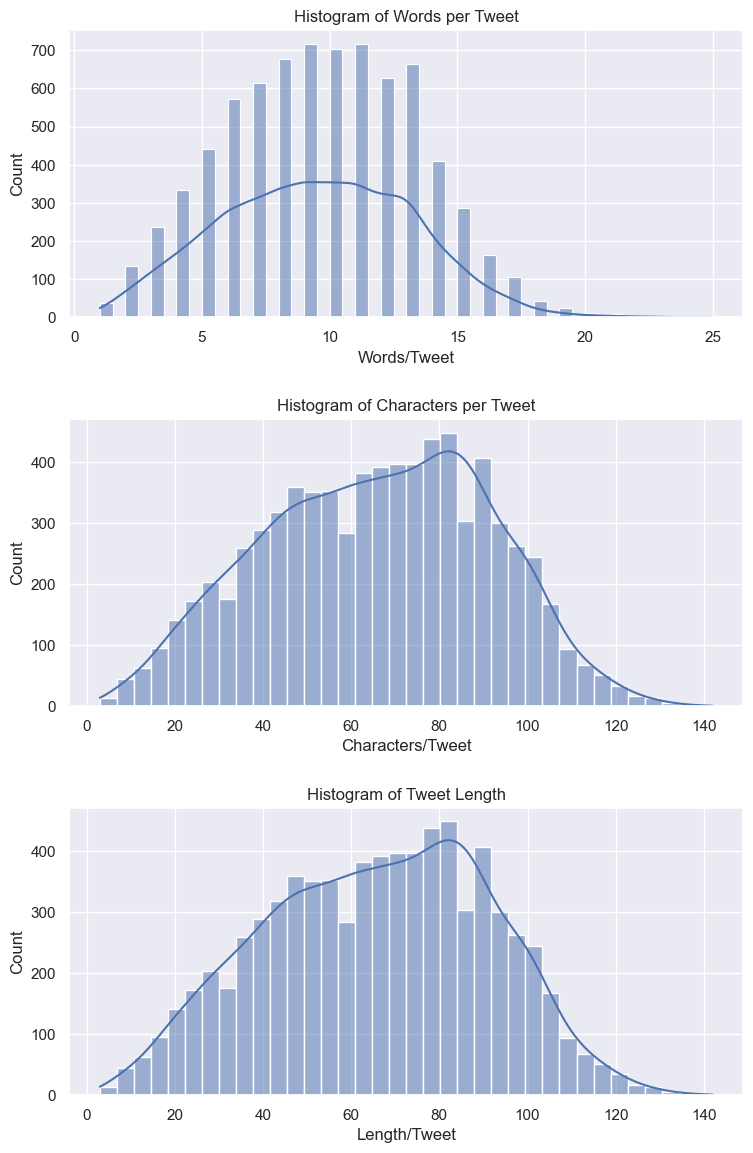

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize figure
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# Plot charts
axs[0] = sns.histplot(chart_df, x='Words', kde=True, ax=axs[0])
axs[0].set(title='Histogram of Words per Tweet')
axs[0].set(xlabel='Words/Tweet', ylabel='Count')

axs[1] = sns.histplot(chart_df, x='Chars', kde=True, ax=axs[1])
axs[1].set(title='Histogram of Characters per Tweet')
axs[1].set(xlabel='Characters/Tweet', ylabel='Count')

axs[2] = sns.histplot(chart_df, x='Length', kde=True, ax=axs[2])
axs[2].set(title='Histogram of Tweet Length')
axs[2].set(xlabel='Length/Tweet', ylabel='Count')

plt.tight_layout(pad=2.0)
plt.show()
plt.close()
None

### 4.3 Histograms of Text Polarity and Subjectivity

Histograms of text polarity and subjectivity are graphical representations of the distribution of sentiment analysis scores for a given text dataset. Text polarity refers to the sentiment or emotional tone of a given text, and is typically scored on a scale ranging from -1 (most negative) to +1 (most positive). Subjectivity, on the other hand, refers to the degree to which a text expresses personal opinions or feelings, and is generally scored on a scale ranging from 0 (most objective) to 1 (most subjective). 

Histograms of text polarity and subjectivity provide a summary of the sentiment and objectivity of the text data, which can be useful in many applications such as market research, social media analysis, and customer feedback analysis. By examining the distribution of polarity and subjectivity scores, one can gain insights into the overall tone of the text dataset and how opinions or emotions are expressed.

In our case, the vast majority of texts are neutral in terms of polarity and objective in terms of subjectivity. This can actually be advantageous when building a classification model, as it eliminates the possibility of emotions interfering with the task at hand. This allows for a more objective approach to categorizing the text, leading to potentially more accurate results.

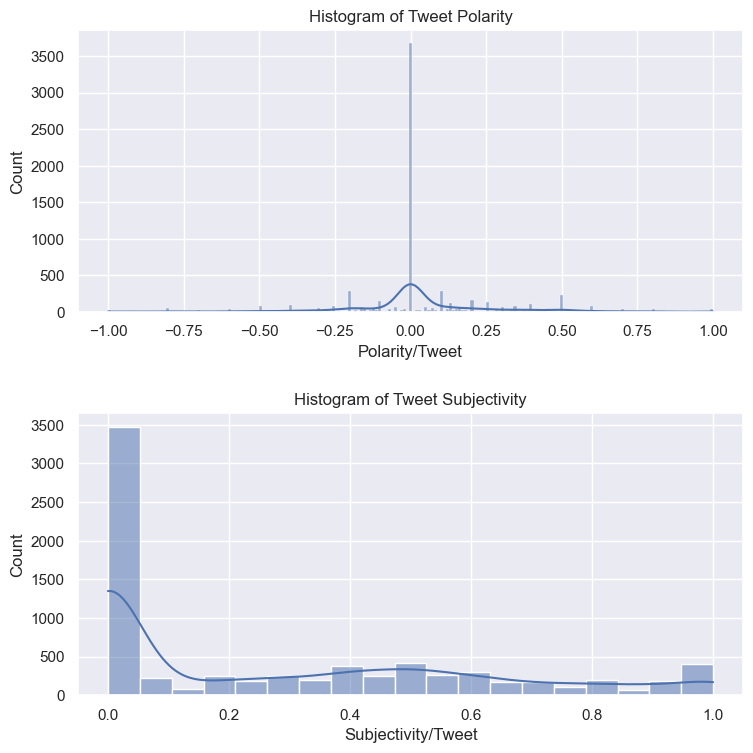

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize figure
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

# Plot charts
axs[0] = sns.histplot(chart_df, x='Polarity', kde=True, ax=axs[0])
axs[0].set(title='Histogram of Tweet Polarity')
axs[0].set(xlabel='Polarity/Tweet', ylabel='Count')

axs[1] = sns.histplot(chart_df, x='Subjectivity', kde=True, ax=axs[1])
axs[1].set(title='Histogram of Tweet Subjectivity')
axs[1].set(xlabel='Subjectivity/Tweet', ylabel='Count')

plt.tight_layout(pad=2.0)
plt.show()
plt.close()
None

### 4.4 - Wordcloud

A wordcloud is a graphical representation of textual data that displays the most frequently occurring words in a corpus, with the size of each word indicating its relative frequency. The words are arranged in a visually appealing way, often in a random or scattered pattern, with the most frequent words appearing in the largest font size and less frequent words appearing in progressively smaller sizes. Wordclouds can be useful for quickly identifying the most important or frequently used words in a text or corpus, and can help to highlight patterns, themes, or trends that may be present.

The fact that words such as "death" and "fire" appear among the most common in the dataset is intriguing. However, it is important to consider that this may be a result of the way the dataset was selected by Kaggle for the project. In a real-world scenario, the most common words may differ significantly depending on the context and subject matter of the dataset.

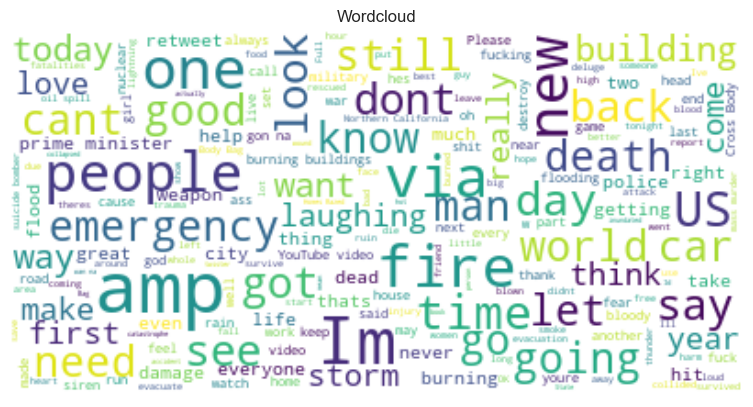

In [27]:
# Create word list
text_list = list(train_df['text'])
words = ''.join(text_list)

# Initialize figure
plt.figure(figsize=(8, 5))
ax = plt.axes()

# Plot chart
wordcloud = WordCloud(background_color='white', max_font_size=40).generate(words)
plt.imshow(wordcloud, interpolation='bilinear')

# Set Properties
ax.set(title='Wordcloud')
plt.axis('off')
plt.tight_layout(pad=2.0)
plt.show()
plt.close()
None

### 4.5 Top-10 Keywords

As previously mentioned, the keyword column will not be utilized for building the model due to a lack of reliability and consistency in their definitions. The presence of ambiguity and subjectivity in the keyword definitions means that they cannot be consistently applied to the texts, making them an unreliable source of information for model development.

Despite this, it is still interesting to explore the frequency of the top-10 keywords used in the texts. This information can provide valuable insights into the language used within the dataset and identify any notable patterns or trends. Additionally, analyzing the keywords can be helpful in identifying the main themes and topics of the texts.

However, it is important to note that this analysis should be approached with caution, as the keywords may not always accurately reflect the main themes or topics of the texts. This is especially true if the dataset has not been manually curated and the keywords have been generated automatically. In such cases, the keywords may not capture the nuances and complexities of the text, leading to a potential misrepresentation of its meaning.

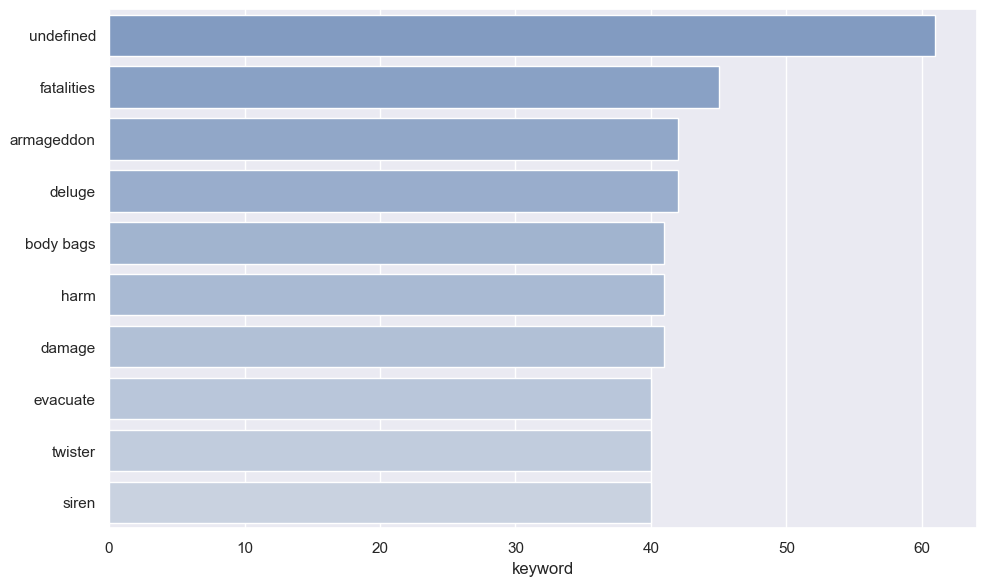

In [28]:
# Initialize figure
fig, axs = plt.subplots(1, 1, figsize=(10, 6))

# Set Seaborn style
sns.set(style='darkgrid')
palette_color = sns.light_palette(color='#79C', reverse=True, n_colors=15)

# Get top-10 keywords
top_keywords=train_df['keyword'].value_counts()[:10]

# Create plots
axs = sns.barplot(x=top_keywords, y=top_keywords.index, 
                  palette=palette_color)

# Show plots
plt.tight_layout(pad=1.0)
plt.show()
plt.close()
None

## 5 - Data Preprocessing

### 5.1 - Word Embedding

Word embedding is used to convert input words into a continuous vector representation before feeding them into the network. The embedding layer learns a mapping between words and their corresponding dense vector representations, based on the context in which they appear in the training data. The output of the embedding layer is then fed into the recurrent layer of the network for processing.

There are several popular word embedding techniques that can be used for RNN-based NLP tasks, including Word2Vec, GloVe, and FastText. Each of these techniques has its own strengths and weaknesses, and the choice of which one to use depends on various factors such as the size of the dataset, the complexity of the task, and the available computing resources.

For binary classification of a text, which is the focus of this project, the following techniques can be typically used:

* **GloVe** is a popular choice for many NLP tasks, including sentiment analysis and text classification. It is based on a co-occurrence matrix of words in a large text corpus and learns word embeddings that capture both syntactic and semantic relationships between words.

* **FastText** is another popular word embedding technique that is based on the skip-gram model of Word2Vec. In addition to learning word embeddings, FastText also learns character n-gram embeddings that can capture morphological information of words. This can be particularly useful for tasks such as sentiment analysis, where the meaning of a word can be influenced by its context and morphological features.

* **Word2Vec** is also a popular word embedding technique that can be used for RNN-based NLP tasks, including binary classification of tweets. Word2Vec is based on the skip-gram and continuous bag of words (CBOW) models, which learn word embeddings based on the context in which they appear in a large text corpus.

### 5.2 - Plan of Analysis

Compared to GloVe and FastText, Word2Vec typically requires more training data to learn high-quality embeddings. However, it is known to perform well on tasks such as semantic similarity and analogy detection, which require a good understanding of the underlying semantic relationships between words. The dataset used for this project is fairly small so I anticipate that it may not be the best choice.

Given that the goal of this project is to perform binary classification of tweets, both GloVe and FastText are suitable techniques for the task. However, since the focus of the project is not sentiment analysis, I will lean towards using GloVe as it is a popular choice that has been successfully used in many similar text classification projects. GloVe embeddings are known for capturing both semantic and syntactic relationships between words, which can be particularly useful for this task. Therefore, I believe that GloVe is a good choice for this project.

In [30]:
%%time

# Initialize an empty dictionary to store the embeddings
embeddings_index = {}

# Open the GloVe word embedding file and read each line
f = open(GLOVE_PATH + '\glove.6B.100d.txt', encoding='utf-8')
for line in f:
    
    # Split each line into a list of values
    values = line.split()
    
    # The first value is the word
    word = values[0]
    
    # The remaining values are the coefficients for the word embedding
    coefs = np.asarray(values[1:], dtype='float32')
    
    # Store the word embedding coefficients in the dictionary using the word as the key
    embeddings_index[word] = coefs
    
# Close GloVe file    
f.close()

Wall time: 9.1 s


In [31]:
# set the maximum number of features to keep
max_features = 1000

# create a tokenizer with the specified number of words to keep
tokenizer = Tokenizer(num_words=max_features)

# fit the tokenizer on the training data text
tokenizer.fit_on_texts(train_df['text'].values)

# convert the text to sequences of integers
X = tokenizer.texts_to_sequences(train_df['text'].values)
X_test = tokenizer.texts_to_sequences(test_df['text'].values)

# pad the sequences to a fixed length
X = pad_sequences(X)
X_test = pad_sequences(X_test)

In [32]:
# Split the data into training and testing sets
Y = train_df['target'].values
X_train, X_val, y_train, y_val = train_test_split(X, Y, 
                                                  test_size=0.2, 
                                                  random_state=RANDOM_STATE)

In [33]:
# Define embedding dimension
embedding_dim = 100

# Get word index from the tokenizer
word_index = tokenizer.word_index

# Create the embedding matrix
embedding_matrix = np.zeros((max_features, embedding_dim))

# Loop through the word index to get the corresponding embedding vector for each word
for word, i in word_index.items():
    
    # If the index is greater than or equal to the max features, skip it
    if i >= max_features:
        continue
        
    # Get the embedding vector for the word from the GloVe embeddings
    embedding_vector = embeddings_index.get(word)
    
    # If the embedding vector is not None, add it to the embedding matrix
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## 6 - Model Architecture

To build a robust and accurate model for my NLP task, I plan to follow a four-step approach involving building a baseline model using the basic building blocks of an RNN architecture for NLP, optimizing the model using various techniques learned in class, and leveraging other types of architectures. By building a solid foundation with the baseline model, I can then experiment with different optimization techniques such as hyperparameter tuning, early stopping, and learning rate to improve the model's performance. Additionally, I can leverage other types of architectures such as bidirectional LSTM and GRU to further enhance the model's ability to handle sequential data with long-term dependencies

**Step 1:** Building Baseline using LSRT Model

* To build a baseline RNN model architecture, start by using the Long Short-Term Memory (LSTM) model, which can handle sequential data with long-term dependencies.
* Train the LSRT model using backpropagation through time (BPTT) to optimize the model's parameters and minimize the prediction error.
* Test the LSRT model using a validation set to measure its performance, such as accuracy, AUC, MSE and F1 score.

**Step 2:** Optimizing LSRT Model

* To optimize the LSRT model, tune its hyperparameters, such as the number of hidden layers, the number of hidden units in each layer, the learning rate, and the regularization parameters.
* Use techniques such as early stopping or learning rate to prevent overfitting and improve the convergence rate of the model.

**Step 3:** Applying optimizations from step 2 and building bidirectional LSTM model

* Apply the hyperparameter optimizations from step 2 to build a bidirectional LSTM (BLSTM) model, which can process sequential data in both forward and backward directions.
* Train the BLSTM model using BPTT with the optimized hyperparameters and test it on the validation set.
* Evaluate the BLSTM model on a test set to measure its generalization performance and compare it to the baseline LSRT model.

**Step 4:** Applying optimizations from step 2 and building bidirectional GRU model

* Apply the hyperparameter optimizations from step 2 to build a bidirectional Gated Recurrent Unit (BGRU) model, which can handle sequential data with long-term dependencies and reduce the computational cost compared to LSTM.
* Train the BGRU model using BPTT with the optimized hyperparameters and test it on the validation set.
* Evaluate the BGRU model on a test set to measure its generalization performance and compare it to the baseline LSRT and BLSTM models.

### 6.1 Helper Functions

This section contains a collection of functions that will be used for various common tasks, such as plotting and reporting. These functions are designed to simplify the coding process.

In [34]:
"""
Plot AUC, MSE, Accuracy and Recall charts for a given model
Inputs:
    chart_df: Pandas dataframe with metrics computed during training
    plot_val: boolean to indicate whether to plot validation results
Outputs:
    None
"""
def plot_results(chart_df, plot_val=True):
    
    # Initialize figure
    fig, axs = plt.subplots(2, 2, figsize=(12, 6))

    # Set Seaborn style
    sns.set(style='darkgrid')

    # Create lineplots
    axs[0, 0] = sns.lineplot(data=chart_df, x='epoch', y='auc', ax=axs[0, 0])
    axs[0, 1] = sns.lineplot(data=chart_df, x='epoch', y='mse', ax=axs[0, 1])
    axs[1, 0] = sns.lineplot(data=chart_df, x='epoch', y='accuracy', ax=axs[1, 0])
    axs[1, 1] = sns.lineplot(data=chart_df, x='epoch', y='f1', ax=axs[1, 1])
    
    # Plot validation results if requested
    if plot_val: 
        axs[0, 0] = sns.lineplot(data=chart_df, x='epoch', y='val_auc', ax=axs[0, 0])
        axs[0, 1] = sns.lineplot(data=chart_df, x='epoch', y='val_mse', ax=axs[0, 1])
        axs[1, 0] = sns.lineplot(data=chart_df, x='epoch', y='val_accuracy', ax=axs[1, 0])
        axs[1, 1] = sns.lineplot(data=chart_df, x='epoch', y='val_f1', ax=axs[1, 1])        
        fig.legend(labels=['train', 'validation'], loc='lower left')
    else:
        fig.legend(labels=['train'], loc='lower left')

    # Axes labels
    axs[0, 0].set(xlabel='Epoch', ylabel='AUC')        
    axs[0, 1].set(xlabel='Epoch', ylabel='MSE')
    axs[1, 0].set(xlabel='Epoch', ylabel='Accuracy')   
    axs[1, 1].set(xlabel='Epoch', ylabel='F1 Score')    

    # Define a fixed y axis range for consistency
    axs[0, 0].set(ylim=(0.7, 0.95))    
    axs[0, 1].set(ylim=(0.1, 0.2))
    axs[1, 0].set(ylim=(0.7, 0.9))
    axs[1, 1].set(ylim=(0.6, 0.9))
    
    # Show plot
    plt.tight_layout(pad=1.2)
    plt.show()
    plt.close()
    None

In [35]:
"""
Custom functions to calculate recall, precision and F1 in Keras since 
  not all are available in 2.0
Inputs:
    y_true: true labels (automatically passed by fit method)
    y_pred: predicted labels (automatically passed by fit method)
Outputs:
    Computed metric
"""

# Define a function for calculating recall
def recall_metric(y_true, y_pred):
    
    # Calculate the number of true positives
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    # Calculate the number of possible positives
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    # Calculate the recall value
    recall = true_positives / (possible_positives + K.epsilon())
    
    # Return the recall value
    return recall

# Define a function for calculating precision
def precision_metric(y_true, y_pred):
    
    # Calculate the number of true positives
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    # Calculate the number of predicted positives
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
    # Calculate the precision value
    precision = true_positives / (predicted_positives + K.epsilon())
    
    # Return the precision value
    return precision


# Define a function for calculating F1-score
def f1(y_true, y_pred):
    
    # Calculate the precision value
    precision = precision_metric(y_true, y_pred)
    
    # Calculate the recall value
    recall = recall_metric(y_true, y_pred)
    
    # Calculate the F1-score value
    f1_score = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
    
    # Return the F1-score value
    return f1_score

In [36]:
# Get longest sentence in training data
# maxlen = train_df['text'].apply(lambda x: len(x.split())).max()

# # Define vocabulary size
# vocab_size = len(word_index) + 1

### 4.2 Base LSTM Model

For the base model, I have chosen a commonly used RNN architecture for NLP that provides a simple yet effective starting point by using basic building blocks of a typical RNN architecture. This architecture is a Sequential model in Keras that consists of three layers: an embedding layer, an LSTM layer, and a dense layer. 

1 - Embedding layer:

* **input_dim:** the size of the vocabulary, which is set to max_features.
* **output_dim:** the size of the embedding vectors, which is set to embedding_dim.
* **weights:** the pre-trained embedding matrix that is passed as input to the embedding layer.
* **input_length:** the length of the input sequences, which is set to X.shape[1].
* **trainable:** a boolean parameter that indicates whether the embedding layer should be trainable or not. In this case, it is set to False since the embedding matrix is pre-trained.

2 - LSTM layer:
* **Number of memory units:** 128
* **Dropout rate:** 0.2, which means that 20% of the inputs to the LSTM layer will be randomly set to 0 during training to prevent overfitting
* **Recurrent dropout rate:** 0.2, which means that 20% of the recurrent connections in the LSTM layer will be randomly set to 0 during training to prevent overfitting
* **Unroll:** True, which means that the LSTM layer will be unrolled (expanded into multiple time steps) for faster computation

3 - Dense layer:
* **Number of units:** 1, which represents the binary classification output
* **Activation function:** 'sigmoid', which squashes the output to a probability between 0 and 1

4 - Optimizer:
* **Adam optimizer** with a learning rate of 0.001, which is a popular optimization algorithm for deep learning models

5 - Loss function:
* **Binary cross-entropy** loss function, which is commonly used for binary classification problems

6 - Metrics:
* **f1:** F1 score, which is the harmonic mean of precision and recall
* **'accuracy':** Classification accuracy, which is the proportion of correctly classified samples
* **'AUC':** Area under the receiver operating characteristic (ROC) curve, which measures the trade-off between true positive rate and false positive rate
* **'mse':** Mean squared error, which measures the average squared difference between the predicted and true values

7 - Training parameters:
* **Batch size:** 128, which represents the number of samples that are processed together in each forward/backward pass during training
* **Number of epochs:** epochs, which represents the number of times the entire training dataset is processed during training.

In [37]:
# Number of epochs used by all models
epochs=20

In [38]:
%%time

# Define the model
model = Sequential()
model.add(Embedding(input_dim=max_features, 
                    output_dim=embedding_dim, 
                    weights=[embedding_matrix], 
                    input_length=X.shape[1], 
                    trainable=False))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, unroll=True))
model.add(Dense(1, activation='sigmoid'))

# Set up the optimizer
optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=optimizer,
              metrics=[f1, 'accuracy', 'AUC', 'mse'])

# Print model summary
model.summary()

# Train the model
model_history = model.fit(X_train, y_train, 
                          validation_data=(X_val, y_val),
                          batch_size=128,
                          epochs=epochs)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 17, 100)           100000    
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 217,377
Trainable params: 117,377
Non-trainable params: 100,000
_________________________________________________________________
Epoch 1/20
48/48 [==============================] - 10s 68ms/step - loss: 0.5322 - f1: 0.6859 - accuracy: 0.7508 - auc: 0.8047 - mse: 0.1773 - val_loss: 0.5131 - val_f1: 0.6593 - val_accuracy: 0.7594 - val_auc: 0.8121 - val_mse: 0.1689
Epoch 2/20
48/48 [==============================] - 2s 44ms/step - loss:

In [39]:
# Create Pandas dataframe with metrics from training
chart_df = pd.DataFrame(model_history.history)
chart_df.insert(loc=0, column='epoch', value=np.arange(1, len(chart_df) + 1))
chart_df.insert(loc=0, column='model', value='Base LSTM Model')

# Create a summary dataframe to be used for final comparison and
#   add the epoch with best AUC result
summary_df = chart_df.sort_values(by=['val_f1'], 
                                  ascending=False)[0:1].copy()
summary_df.reset_index(inplace=True, drop=True)
chart_df.sort_values(by=['val_f1'], ascending=False)[0:1]

,model,epoch,loss,f1,accuracy,auc,mse,val_loss,val_f1,val_accuracy,val_auc,val_mse
13,Base LSTM Model,14,0.395881,0.779041,0.825597,0.891916,0.126412,0.487575,0.734281,0.792578,0.835287,0.155889


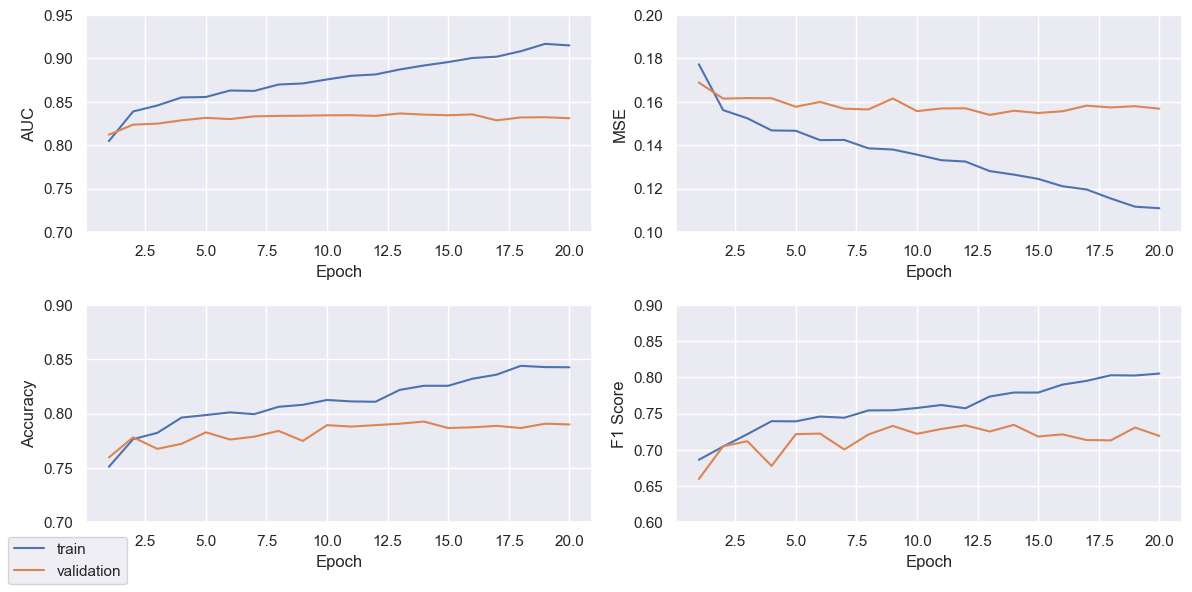

In [40]:
plot_results(chart_df)

### Analysis of the Results

> * After 20 epochs, the model performs well on the training data, achieving relatively high accuracy and F1 scores, as well as low MSE. 
> * However, the model is overfitting to the training data, which becomes evident when we compare its performance on the validation set to its performance on the training set. As we train the model for more epochs, this difference between train and validation results becomes larger.
> * To address this issue, I will explore various techniques aimed at reducing overfitting and improving the model's generalization performance.

### 4.3 - Optimized LSTM Model

To address the overfitting problem experienced in the base model, I will make the following changes to the base model:

* **Reduce the number of units in the LSTM layer:** I will reduce the number of units in the LSTM layer from the previous model to 64 to reduce the model's complexity and prevent overfitting.

* **Add a second LSTM layer:** I will add another LSTM layer with the same number of units (64) as the first layer. This can help the model learn more complex relationships between the input sequences and improve its performance on the validation set.

* **Add Dropout layers before and after the LSTM layer:** I will add two Dropout layers, one before and one after the LSTM layer, using a dropout rate of 0.2. This will randomly drop out 20% of the input units during training, which can help prevent overfitting and improve generalization performance.

* **Add L2 regularization to the Dense layer:** I will add L2 regularization to the Dense layer with a regularization strength of 0.01. This can help prevent overfitting by adding a penalty term to the loss function that encourages the model to learn simpler representations.

In [41]:
%%time

model = Sequential()
model.add(Embedding(input_dim=max_features, 
                    output_dim=embedding_dim, 
                    weights=[embedding_matrix], 
                    input_length=X.shape[1], 
                    trainable=False))
model.add(Dropout(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, unroll=True, return_sequences=True))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, unroll=True))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))

# Set up the optimizer
optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=optimizer,
              metrics=[f1, 'accuracy', 'AUC', 'mse'])

# Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Print model summary
model.summary()

# Train the model with early stopping and validation split
model_history = model.fit(X_train, y_train, 
                          validation_data=(X_val, y_val),
                          batch_size=128,
                          callbacks=[early_stop],
                          epochs=epochs)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 17, 100)           100000    
                                                                 
 dropout (Dropout)           (None, 17, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 17, 64)            42240     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 175,329
Trainable params: 75,329
Non-tra

In [42]:
# Create Pandas dataframe with metrics from training
chart_df = pd.DataFrame(model_history.history)
chart_df.insert(loc=0, column='epoch', value=np.arange(1, len(chart_df) + 1))
chart_df.insert(loc=0, column='model', value='Optimized LSTM Model')

# Append epoch with best AUC result to summary dataframe 
summary_df = summary_df.append(chart_df.sort_values(by=['val_f1'], 
                                                    ascending=False)[0:1].copy())
summary_df.reset_index(inplace=True, drop=True)
chart_df.sort_values(by=['val_f1'], ascending=False)[0:1]

,model,epoch,loss,f1,accuracy,auc,mse,val_loss,val_f1,val_accuracy,val_auc,val_mse
14,Optimized LSTM Model,15,0.446912,0.749074,0.804211,0.864265,0.14154,0.486765,0.731264,0.791252,0.835172,0.155301


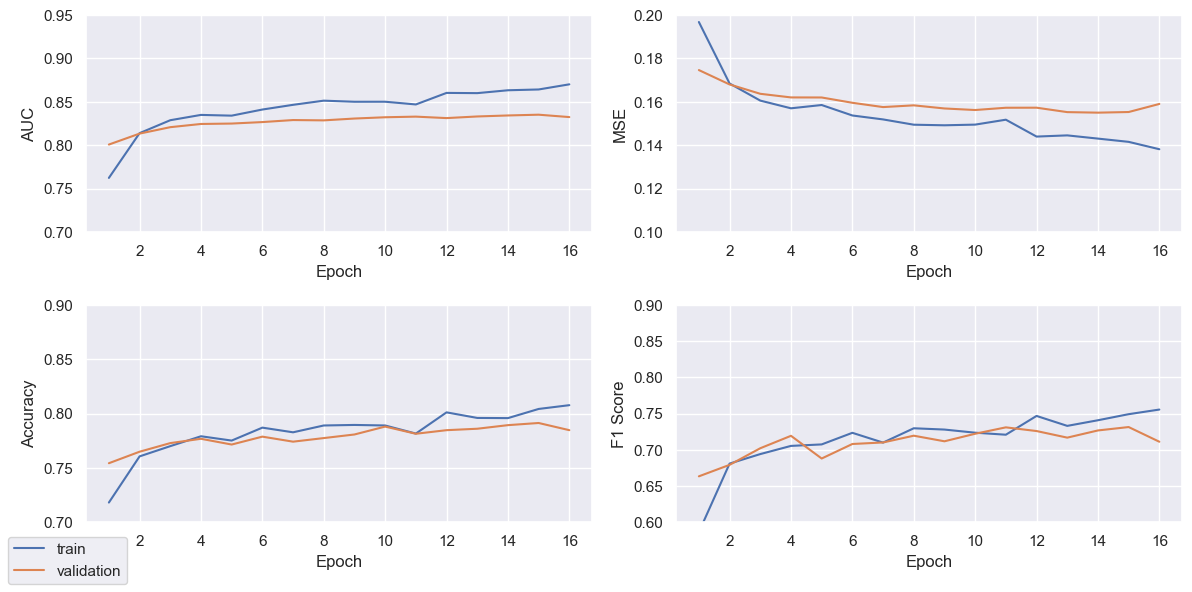

In [43]:
plot_results(chart_df)

### Analysis of the Results

> * After implementing the changes to address the overfitting problem in the base model, it is clear that the optimized model worked much better and significantly reduced the overfitting. 
> * There was a small drop in accuracy and F1 scores for the training data, but this is actually a positive change because it reflects a more realistic result, given the fact that the results on the validation data performed almost as well as the training data.
> * In the next iterations, I will experiment with other models to attempt to achieve better model performance. Specifically, I plan to try bidirectional LSTM and GRU models. 

### 4.4 - Optimized Bi-Directional LSTM Model

The next model maintains the optimization parameters that achieved good results in the previous model but will use a **bidirectional LSTM model**. Bidirectional LSTM can potentially capture long-term dependencies in both forward and backward directions and may be better suited for some applications including NLP tasks.

In [44]:
%%time

model = Sequential()
model.add(Embedding(input_dim=max_features, 
                    output_dim=embedding_dim, 
                    weights=[embedding_matrix], 
                    input_length=X.shape[1], 
                    trainable=False))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2, unroll=True, 
                             return_sequences=True)))
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2, unroll=True)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))

# Set up the optimizer
optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=optimizer,
              metrics=[f1, 'accuracy', 'AUC', 'mse'])

# Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Print model summary
model.summary()

# Train the model with early stopping and validation split
model_history = model.fit(X_train, y_train, 
                          validation_data=(X_val, y_val),
                          batch_size=128,
                          callbacks=[early_stop],
                          epochs=epochs)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 17, 100)           100000    
                                                                 
 dropout_2 (Dropout)         (None, 17, 100)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 17, 128)          84480     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [45]:
# Create Pandas dataframe with metrics from training
chart_df = pd.DataFrame(model_history.history)
chart_df.insert(loc=0, column='epoch', value=np.arange(1, len(chart_df) + 1))
chart_df.insert(loc=0, column='model', value='Optimized Bidirectional LSTM Model')

# Append epoch with best AUC result to summary dataframe 
summary_df = summary_df.append(chart_df.sort_values(by=['val_f1'], 
                                                    ascending=False)[0:1].copy())
summary_df.reset_index(inplace=True, drop=True)
chart_df.sort_values(by=['val_f1'], ascending=False)[0:1]

,model,epoch,loss,f1,accuracy,auc,mse,val_loss,val_f1,val_accuracy,val_auc,val_mse
13,Optimized Bidirectional LSTM Model,14,0.437862,0.749732,0.807858,0.8683,0.139025,0.491581,0.733313,0.79059,0.835242,0.155648


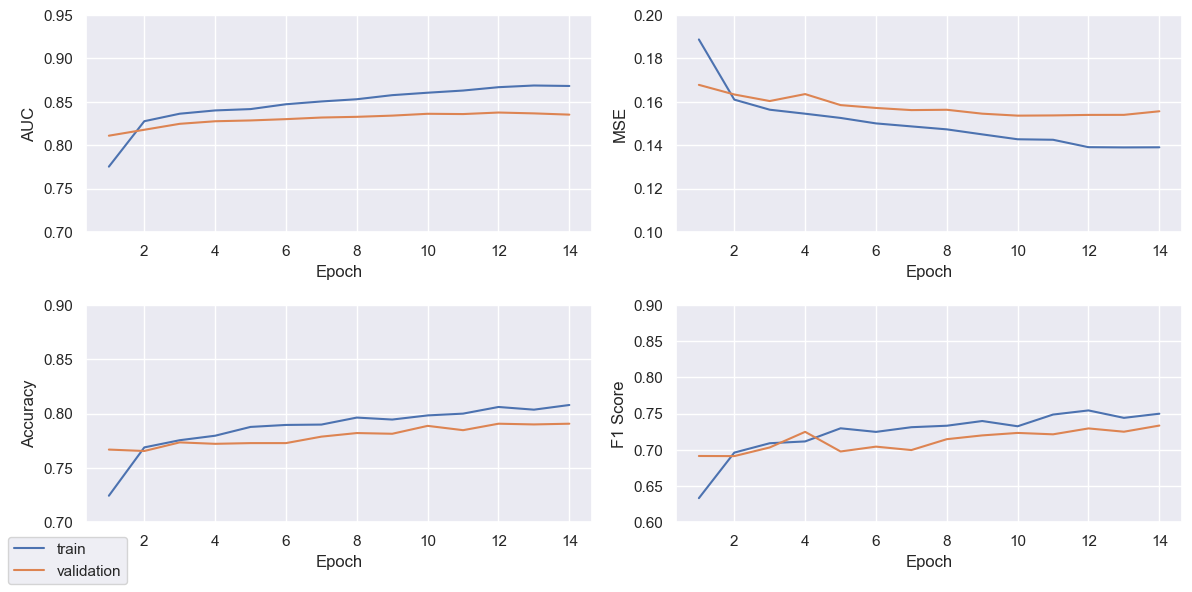

In [46]:
plot_results(chart_df)

### Analysis of the Results

* After experimenting with the bidirectional LSTM model, it is clear that it worked very similarly to the optimized LSTM model used previously. 

* Both models achieved similar metrics, including accuracy and F1 scores, and there were no major signs of overfitting in either model.

* Based on these results, I would conclude that either model would be suitable for the task at hand. The choice between these models may come down to other factors, such as computational resources, ease of implementation, or the amount of data available for use in real-cases scenarios.

### 4.5 - Optimized Bi-Directional GRU Model

For the last model I will also maintain the optimization parameters that achieved good results in the previous models but will use a bidirectional GRU model. Bidirectional GRU is a type of recurrent neural network that can be faster to train and has been shown to work well in some natural language processing tasks.

In [47]:
%%time

model = Sequential()
model.add(Embedding(input_dim=max_features, 
                    output_dim=embedding_dim, 
                    weights=[embedding_matrix], 
                    input_length=X.shape[1], 
                    trainable=False))
model.add(Dropout(0.2))
model.add(Bidirectional(GRU(64, dropout=0.2, recurrent_dropout=0.2, unroll=True,
                           return_sequences=True)))
model.add(Bidirectional(GRU(64, dropout=0.2, recurrent_dropout=0.2, unroll=True)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))

# Set up the optimizer
optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=optimizer,
              metrics=[f1, 'accuracy', 'AUC', 'mse'])

# Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Print model summary
model.summary()

# Train the model with early stopping and validation split
model_history = model.fit(X_train, y_train, 
                          validation_data=(X_val, y_val),
                          batch_size=128,
                          callbacks=[early_stop],
                          epochs=epochs)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 17, 100)           100000    
                                                                 
 dropout_4 (Dropout)         (None, 17, 100)           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 17, 128)          63744     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              74496     
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [48]:
# Create Pandas dataframe with metrics from training
chart_df = pd.DataFrame(model_history.history)
chart_df.insert(loc=0, column='epoch', value=np.arange(1, len(chart_df) + 1))
chart_df.insert(loc=0, column='model', value='Optimized Bidirectional GSU Model')

# Append epoch with best AUC result to summary dataframe 
summary_df = summary_df.append(chart_df.sort_values(by=['val_f1'], 
                                                    ascending=False)[0:1].copy())
summary_df.reset_index(inplace=True, drop=True)
chart_df.sort_values(by=['val_f1'], ascending=False)[0:1]

,model,epoch,loss,f1,accuracy,auc,mse,val_loss,val_f1,val_accuracy,val_auc,val_mse
12,Optimized Bidirectional GSU Model,13,0.449251,0.735899,0.794761,0.861593,0.143905,0.495406,0.73597,0.780649,0.835409,0.159654


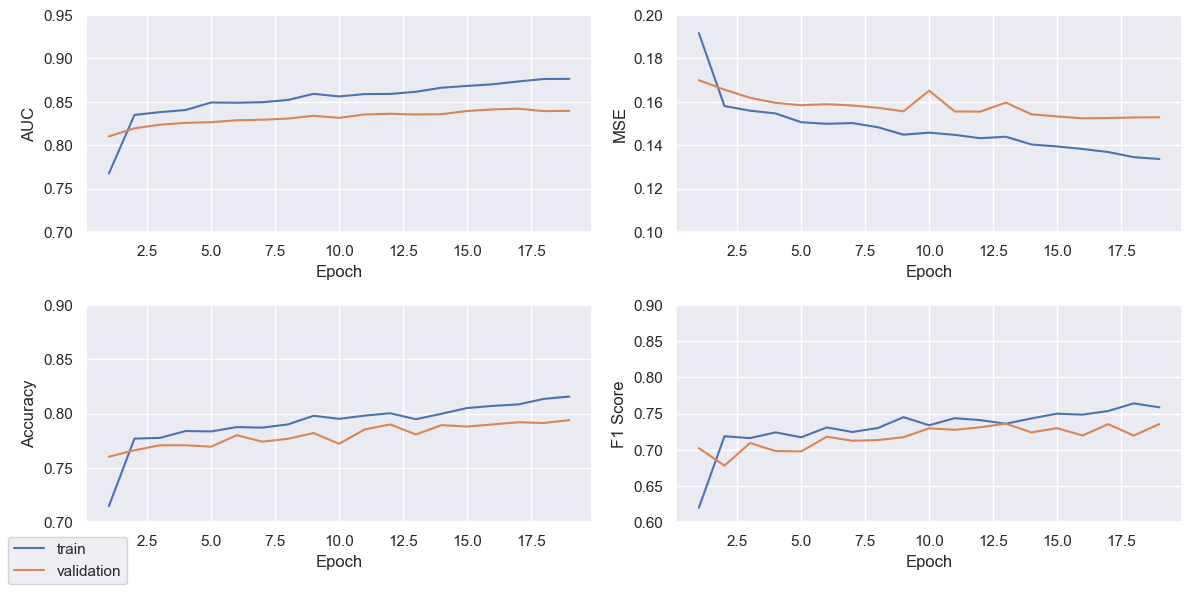

In [49]:
plot_results(chart_df)

### Analysis of the Results

* After experimenting with the bidirectional GRU model, it is clear that it worked very similarly to the previously optimized LSTM and bidirectional LSTM models. All three models achieved similar metrics, including accuracy and F1 scores, and there were no signs of overfitting in any of the models.

* Additionally, from the execution time perspective, there was no noticeable difference between these models with all completing training in less than 3 minutes.

* Based on these results, I would conclude that any of these models would be suitable for the task at hand. The choice between these models may depend on other factors, such as computational resources, ease of implementation, or the amount of data available for use in real-world scenarios. For example, if computational resources are limited, the GRU model may be a better choice because it is faster to train than LSTM models on larger datasets.

In [50]:
# Add a column to indicate the relative performance between 
#   validation and training data for F1 score
summary_df.insert(loc=9, column='f1_delta_pct', 
                  value=round((1 - summary_df['val_f1'] / 
                               summary_df['f1']) * 100, 2))

summary_df.sort_values(by=['val_f1'], ascending=False)

,model,epoch,loss,f1,accuracy,auc,mse,val_loss,val_f1,f1_delta_pct,val_accuracy,val_auc,val_mse
3,Optimized Bidirectional GSU Model,13,0.449251,0.735899,0.794761,0.861593,0.143905,0.495406,0.735970,-0.01,0.780649,0.835409,0.159654
0,Base LSTM Model,14,0.395881,0.779041,0.825597,0.891916,0.126412,0.487575,0.734281,5.75,0.792578,0.835287,0.155889
2,Optimized Bidirectional LSTM Model,14,0.437862,0.749732,0.807858,0.868300,0.139025,0.491581,0.733313,2.19,0.790590,0.835242,0.155648
1,Optimized LSTM Model,15,0.446912,0.749074,0.804211,0.864265,0.141540,0.486765,0.731264,2.38,0.791252,0.835172,0.155301


### 4.6 - Final Model Building

After conducting numerous tests using different train-test splits, the **Optimized LSTM Model** is the one that performed more consistently against the other models. As a result, I have decided to utilize it to train the final model.

In [51]:
%%time

model = Sequential()
model.add(Embedding(input_dim=max_features, 
                    output_dim=embedding_dim, 
                    weights=[embedding_matrix], 
                    input_length=X.shape[1], 
                    trainable=False))
model.add(Dropout(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, unroll=True, return_sequences=True))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, unroll=True))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))

# Set up the optimizer
optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=optimizer,
              metrics=[f1, 'accuracy', 'AUC', 'mse'])

# Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Print model summary
model.summary()

# Train the model with early stopping and validation split
model_history = model.fit(X_train, y_train, 
                          validation_data=(X_val, y_val),
                          batch_size=128,
                          callbacks=[early_stop],
                          epochs=epochs)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 17, 100)           100000    
                                                                 
 dropout_6 (Dropout)         (None, 17, 100)           0         
                                                                 
 lstm_5 (LSTM)               (None, 17, 64)            42240     
                                                                 
 lstm_6 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 175,329
Trainable params: 75,329
Non-tra

## 7 - Results and Analysis

### 7.1 - Summary of Hyperparameter Optimization Procedure

I experienced overfitting in the process of building the base model. To address that issue and to improve the overall performance of the final model, I tested several different technique and in the end I applied the following hyperparameter optimizations:

* **Reduce the number of units in the LSTM layer:** I will reduce the number of units in the LSTM layer from the previous model to 64 to reduce the model's complexity and prevent overfitting.

* **Add a second LSTM layer:** I will add another LSTM layer with the same number of units (64) as the first layer. This can help the model learn more complex relationships between the input sequences and improve its performance on the validation set.

* **Add Dropout layers before and after the LSTM layer:** I will add two Dropout layers, one before and one after the LSTM layer, using a dropout rate of 0.2. This will randomly drop out 20% of the input units during training, which can help prevent overfitting and improve generalization performance.

* **Add L2 regularization to the Dense layer:** I will add L2 regularization to the Dense layer with a regularization strength of 0.01. This can help prevent overfitting by adding a penalty term to the loss function that encourages the model to learn simpler representations.

### 7.2 - Summary of Metrics

As we can see from the summary below, all models performed very closely in terms of the F1 score on the validation data, which is the primary metric used by the Kaggle competition. However, the optimized models generally did so without overfitting so the choice between these models should not make much difference for the final leaderboard in the competition.

> **Note:** The table below is sorted by F1 score on validation data in descending order

In [52]:
summary_df.sort_values(by=['val_f1'], ascending=False)

,model,epoch,loss,f1,accuracy,auc,mse,val_loss,val_f1,f1_delta_pct,val_accuracy,val_auc,val_mse
3,Optimized Bidirectional GSU Model,13,0.449251,0.735899,0.794761,0.861593,0.143905,0.495406,0.735970,-0.01,0.780649,0.835409,0.159654
0,Base LSTM Model,14,0.395881,0.779041,0.825597,0.891916,0.126412,0.487575,0.734281,5.75,0.792578,0.835287,0.155889
2,Optimized Bidirectional LSTM Model,14,0.437862,0.749732,0.807858,0.868300,0.139025,0.491581,0.733313,2.19,0.790590,0.835242,0.155648
1,Optimized LSTM Model,15,0.446912,0.749074,0.804211,0.864265,0.141540,0.486765,0.731264,2.38,0.791252,0.835172,0.155301


### 7.3 Model Visualization

The plot provides a visual representation of the architecture of the final model, including all layers used. This information can be beneficial for various purposes, such as understanding how the model works, debugging, and making improvements. Each layer in the model is represented by a rectangular block, and the connections between them indicate the flow of data. 

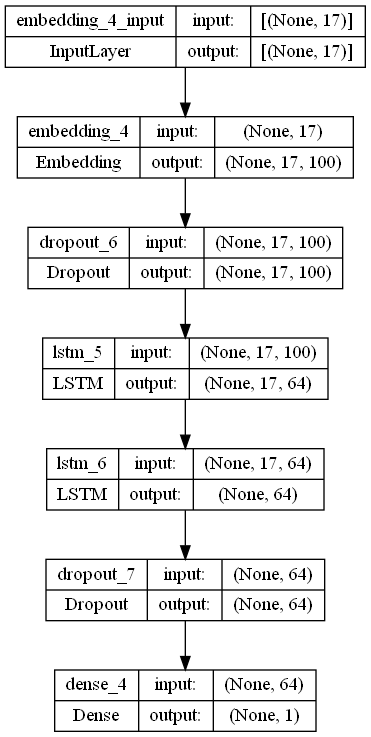

In [53]:
plot_model(model, show_shapes=True, show_layer_names=True)

## 7.4 Confusion Matrix

A confusion matrix is a table that is used to evaluate the performance of a machine learning model by comparing the predicted labels to the true labels. It shows the number of true positives, true negatives, false positives, and false negatives for each category or label in a classification problem.

However, using absolute numbers in a confusion matrix can sometimes be difficult to interpret because it does not take into account the relative proportions of the different categories or labels. For example, a large number of false positives or false negatives in a category with very few instances may not be as important as a smaller number of false positives or false negatives in a category with many instances.

To address this issue, I used percentages instead of absolute numbers. By using percentages, the relative proportions of correct and incorrect classifications for each category can be more easily seen, making it easier to interpret the results.

In [54]:
# make predictions on the training data and convert probabilities into binary
y_probs_train = model.predict(X_train)
y_pred_train = np.where(y_probs_train > 0.5, 1, 0)

# get the true labels of the training data
y_true_train = y_train

# compute the confusion matrix on training data
cm_train = confusion_matrix(y_true_train, y_pred_train)

189/189 [==============================] - 8s 33ms/step


In [55]:
# make predictions on the validation data and convert probabilities into binary
y_probs_val = model.predict(X_val)
y_pred_val = np.where(y_probs_val > 0.5, 1, 0)

# get the true labels of the valing data
y_true_val = y_val

# compute the confusion matrix on valing data
cm_val = confusion_matrix(y_true_val, y_pred_val)

48/48 [==============================] - 2s 33ms/step


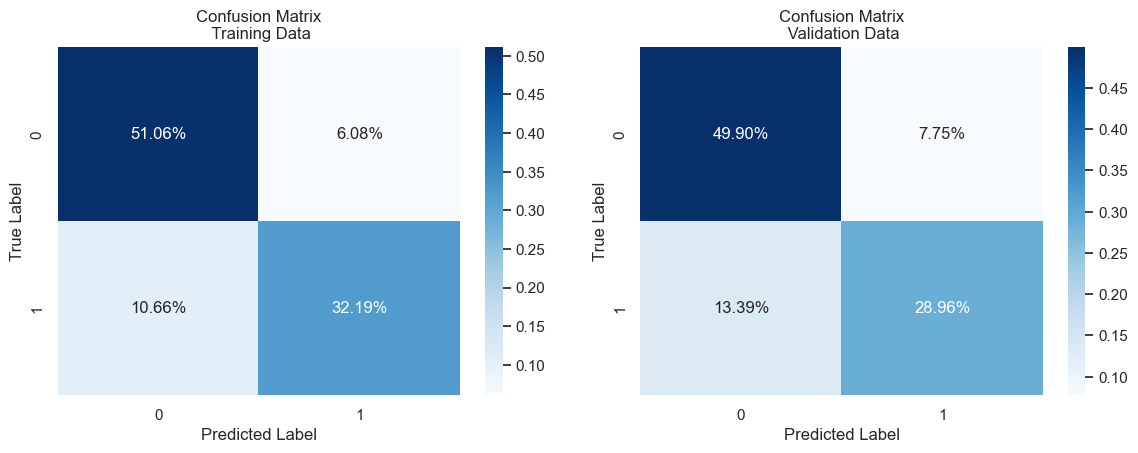

In [56]:
# Initialize figure
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Create plots
axs[0] = sns.heatmap(cm_train/np.sum(cm_train), fmt='.2%',
                     annot=True, cmap='Blues', ax=axs[0])
axs[0].set(title='Confusion Matrix\n Training Data')
axs[0].set(xlabel='Predicted Label', ylabel='True Label')

axs[1] = sns.heatmap(cm_val/np.sum(cm_val), fmt='.2%',
                     annot=True, cmap='Blues', ax=axs[1])
axs[1].set(title='Confusion Matrix\n Validation Data')
axs[1].set(xlabel='Predicted Label', ylabel='True Label')

# Plot charts
plt.tight_layout(pad=2.0)
plt.show()
plt.close()
None

#### Analysis of the Results

* The Confusion Matrix for both the training and validation data sets indicate that the model performed well in identifying true negatives. Almost 50% of the time, the model correctly classified negative samples as negative, which is the best possible result in a binary classification problem.

* However, the Confusion Matrix also shows that the model is having difficulty detecting true positives. In fact, the model classified about 30% of the positive cases correctly. This could be due to a variety of reasons such as an imbalance in the class distribution or insufficient training data for the positive class.

* This result could be concerning if the goal of the model is to identify positive cases accurately. It may be necessary to explore other classification models, adjust the classification threshold, or perform additional feature engineering to improve the model's performance.

### 7.5 ROC-AUC Curve

ROC-AUC is a widely used evaluation metric in binary classification problems. It measures the ability of the model to distinguish between positive and negative instances by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold values. For this project, I provide separate plots for training and validation data,

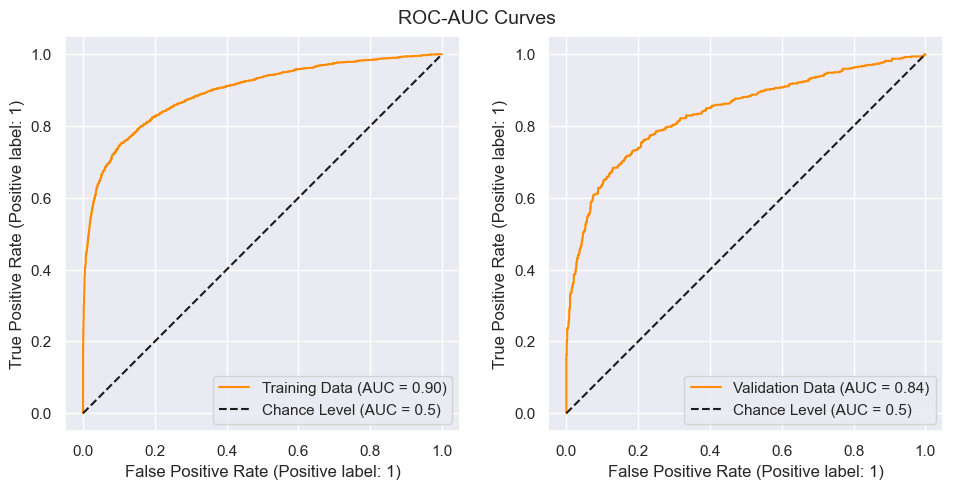

In [57]:
# Initialize figure
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Create ROC-AUC plots
roc_display = RocCurveDisplay.from_predictions(
    y_true_train, y_probs_train, color = 'darkorange', 
    name='Training Data', ax=axs[0])
axs[0].plot([0, 1], [0, 1], 'k--', label='Chance Level (AUC = 0.5)')
axs[0].axis('square')
axs[0].legend(loc='lower right')

roc_display = RocCurveDisplay.from_predictions(
    y_true_val, y_probs_val, color = 'darkorange', 
    name='Validation Data', ax=axs[1])
axs[1].plot([0, 1], [0, 1], 'k--', label='Chance Level (AUC = 0.5)')
axs[1].axis('square')
axs[1].legend(loc='lower right')

# Plot charts
plt.suptitle('ROC-AUC Curves', fontsize=14)   
plt.tight_layout(pad=2.0)
plt.show()
plt.close()
None

#### Analysis of the Results

* While ROC-AUC is not the primary metric used for the Kaggle competition, I believe it is among the best metrics to assess the true performance of a given model because it evaluates the model's performance across all possible thresholds, providing a comprehensive view of the model's ability to distinguish between positive and negative samples.

* In my case, the ROC-AUC curve shows decent results for both the training and test data sets. The ROC-AUC score is around 0.85, indicating that the model is reasonably good at distinguishing between positive and negative samples.

* However, the ROC-AUC curve also demonstrates that there is room for improvement in the model's performance. The curve is right-skewed towards the false positive rate, which suggests that the model is more prone to false positive errors.

* This result is consistent with the findings from the confusion matrix, which also indicated that the model was struggling to detect true positives. 

* To improve the model's performance, it may be necessary to explore other classification models, adjust the classification threshold, or perform additional feature engineering. It is also essential to ensure that the model is not overfitting to the training data, which can be addressed through techniques such as regularization and cross-validation.

### 7.6 - Prediction on Test Data and Result Submission

The purpose of this code is to generate a submission file that can be used to obtain the final score for my model on the original Kaggle competition. The file will contain the predictions made by the optimized model on the test dataset, which is not available to during training. 

In [58]:
# make predictions on the test data and convert probabilities into binary
y_probs_test = model.predict(X_test)
test_df['target'] = np.where(y_probs_test > 0.5, 1, 0)

102/102 [==============================] - 3s 33ms/step


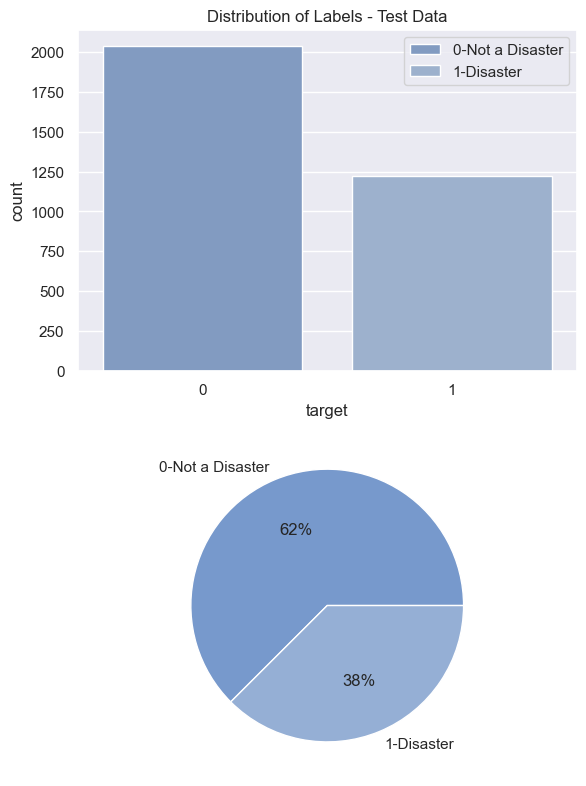

In [59]:
# Initialize figure
fig, axs = plt.subplots(2, 1, figsize=(6, 8))

# Set Seaborn style
sns.set(style='darkgrid')
palette_color = sns.light_palette(color='#79C', reverse=True, n_colors=5)
labels = ['0-Not a Disaster', '1-Disaster']

# Create plots
axs[0] = sns.countplot(x=test_df['target'], hue=test_df['target'], dodge=False,
                       palette=palette_color, ax=axs[0])
axs[0].set_title('Distribution of Labels - Test Data')
axs[0].legend(labels=labels, loc='upper right')

axs[1] = plt.pie(test_df['target'].value_counts().values,
                labels=labels, colors=palette_color, autopct='%.0f%%')


# Show plots
plt.tight_layout(pad=1.0)
plt.show()
plt.close()
None

In [60]:
# Quick visual inspection
test_df.sample(10, random_state=RANDOM_STATE)

,id,keyword,location,text,target
1667,5623,flooding,NaN,Awh damn realized yall gone flooding TL school...,0
2937,9726,tragedy,"Berkeley, CA",MindfulYoga responds tragedy CecilTheLion yoga...,0
1466,4863,explode,sam,happy Justin makes heart explode,0
482,1565,bomb,VI~D[M]V,Hansel Gretel Witch Hunters Bomb ass movie Yeh...,0
3084,10219,volcano,probably watching survivor,sunset looked like erupting volcano initial th...,1
1785,6028,hazardous,Yellowknife NT Canada,Drums Hazardous Waste Dumped Around Kodiak Isl...,1
1239,4070,displaced,"Indianapolis, IN",Job event targets displaced Double 8 employees,0
1046,3438,derail,Road to the Billionaires Club,AshleyDniece GM pray attack enemy 2 derail ur ...,0
607,1982,bush fires,NaN,Bushfire causes first victim Albania multiple ...,1
1744,5878,hailstorm,Ottawa Canada,Hailstorm cleanup begins Calgary,1


In [61]:
# Write file
test_df.loc[:,['id','target']].to_csv(SUBMISSION_PATH + '/submission.csv', index=False)

## 8 - Conclusion

* Based on all the metrics and visualizations I think I can reasonably state that I'm **satisfied with results**. The optimized model reached an F1 score of around **0.75** for both the training data and validation data, which was the primary metric used for the Kaggle competition. In addition, accuracy and ROC-AUC metrics were relatively high also for both test and validation data. 

* My Kaggle submission yielded decent results with a score of **0.79466**. While these scores are not exceptional, it placed me well above the median of all participants. I am confident that I can achieve even better results given more computing resources and time. With additional resources, I could fine-tune our model and explore more complex architectures to improve our results.

* The final model chosen for this NLP project is an **Optimized LSTM Model**, which is a type of Recurrent Neural Network (RNN) that is well-suited for processing sequential data and it proved to work relatively well for the task at hand.

* The Optimized LSTM Model was chosen due to its consistency across multiple train-tests splits, consistent F1 score, and less overfitting. In my opinion, these are critical factors to consider when evaluating the performance of an NLP model, as they indicate the model's ability to generalize well to new data and avoid overfitting.

* The consistent less overfitting observed in the Optimized LSTM Model was the key factor that I considered. While the model didn't necessarily perform best at every train-test split, it didn't fluctuate as much as the other models, which is important when the model is expected to work reliably on new unseen data.

* Also, the consistent F1 score was an essential metric for evaluating the performance of the various models, considering that this was the primary metric used by the Kaggle competition.

### 6.1 - Lessons Learned and Key Takeways

In closing, this project was both fun and informative, providing many valuable lessons for me for future work in the field of RNNs and NLP. Some of the key takeaways from this project for me include:

* One area for improvement in this NLP project could be data preprocessing. Preprocessing steps such as tokenization, stemming, and stop-word removal can improve the quality of the input data and lead to better model performance.

* The need for extensive data preprocessing and cleaning to improve model robustness and generalization for NLP tasks. In my particular case, data preparation was as important as model selection and hyperparameter tuning.

* Another area for improvement could be in hyperparameter tuning. Fine-tuning the hyperparameters of the Optimized LSTM Model could lead to even better performance, particularly in terms of accuracy and F1 score.

* The importance of carefully selecting hyperparameters such as learning rate, batch size, and activation functions. However, despite extensive efforts in searching for the optimal hyperparameters, the performance of the model may not improve significantly or may even worsen. This could be due to various reasons such as a small dataset, imbalanced classes, or high dimensionality of the input data.

* Finally, it is essential to consider the interpretability of the model's results. While deep learning models such as RNNs can achieve impressive performance in NLP tasks, they are often considered "black box" models, making it challenging to understand how the model is making its predictions. Therefore, it may be necessary to explore techniques such as attention mechanisms to improve the interpretability of the model's results.
